In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())

**실버 고객의 중요성 및 마케팅 방향 설정**  

- 서울연구원, 2014년 2월 호, <新실버세대를 위한 젊은 비즈니스>, https://www.si.re.kr/node/48461

“세시봉 콘서트”, “조용필 콘서트”, “이문세 콘서트”에 참석한 중년관객들, ‘7번방의 선물’, ‘광해, 왕이 된 남자’ 등 영화분야에 나타난 50대의 막강해진 티켓파워, “꽃보다 할배”로 인한 노년층의 여행수요 등 과거 소비의 소외층으로 간주되었던 중·고령층들이 점차 소비의 주류층으로 이동하고 있다.

특히 주목할 것은 우리나라 고령화시대를 주도하게 될 베이비부머세대가 2012년 현재 우리나라 총인구 4명 중 1명을 차지할 만큼 큰 규모를 이루고 있을 뿐만 아니라 `자산이나 소득규모에 있어서도 현재의 고령층과는 구별되는 소비여력`을 가지고 있어 새로운 비즈니스의 수요층으로 부상하고 있다는 것이다. 최근 자료에 의하면 노후준비에 있어서도 베이비부머세대는 현재 고령층에 비해 상대적으로 양호한 노후준비를 하고 있는 것으로 조사되었다.  

베이비부머의 신(新)비즈니스 모델들은 소비층의 `다양한 건강상태, 소득수준 및 소비욕구를 반영`한 큰 그림이며, 실제적으로 실버산업 소비자는 다양한 소비욕구를 가진 다양한 계층의 집합체임을 잊어서는 안 된다.

## <목차>
- [1. 데이터 전처리](#1.-데이터-전처리)  
- [2. Food](#2.-Food)
    - [2-1. Clustering (K-Means)](#2-1.-Clustering-(K-Means))  
    - [2-2. 건강식품](#2-2.-건강식품)
- [3. Nofood](#3.-Nofood)
    - [3-1. RFM 분석](#3-1.-RFM-분석)
    - [3-2. 의류잡화](#3-2.-의류잡화)
        - [3-2-1. 주얼리](#3-2-1.-주얼리)
        - [3-2-2. 캐주얼](#3-2-2.-캐주얼)
    - [3-3. 가전제품](#3-3.-가전제품)
        - [3-3-1. 결혼 시기와 연관](#3-3-1.-결혼-시기와-연관)
        - [3-3-2. 가을 & 주방가전](#3-3-2.-가을-&-주방가전)

# 1. 데이터 전처리
- `Demo.csv`, `구매내역정보.csv` 합친 `df`
- 분석에 필요한 열 추가 및 변경
    - 구매일자 : 구매월, 구매요일, 구매계절, 평일주말
    - 성별 : 남,여로 변경
    - 연령 : 연령대
    - 구매시간 : 영업시간 9시~22시로 설정하여 그 외 시간 변경
- 상품대분류명 기준 : 식품 `food` / 비식품 `nofood` 로 분류

**Demo.csv, 구매내역정보.csv 합친 df**

In [ ]:
cs = pd.read_csv('Demo.csv', encoding='cp949', engine='python')
tr = pd.read_csv('구매내역정보.csv', encoding='cp949', engine='python')
df = pd.merge(cs, tr, on='ID')
df.head()

**columns 추가 및 변경**

1. 구매일자 : 구매월, 구매요일, 구매계절, 평일주말

In [ ]:
df.구매일자 = df.구매일자.astype(str).astype('datetime64')
df['구매월'] = df.구매일자.dt.month
df['구매요일'] = df.구매일자.apply(lambda x: ['월', '화', '수', '목', '금', '토', '일'][x.weekday()] +'요일')

In [ ]:
def season(x):
    if 3 <= x <= 5:
        return '봄'
    elif 6 <= x <= 8:
        return '여름'
    elif 9 <= x <= 11:
        return '가을'
    else:
        return '겨울'
    
df['구매계절'] = df.구매월.apply(season)

In [ ]:
df['평일주말'] =  df.구매요일.apply(lambda x : '주말' if x == '토요일' or x == '일요일' else '평일')

2. 성별 : 남, 여로 변경

In [ ]:
df['성별'] = df.성별.apply(lambda x: '남' if x == 1 else '여')

3. 연령 : 연령대

In [ ]:
df['연령대'] = df.연령.astype('str').str[0]+'0대'

4. 구매시간 데이터 변경  
- 오프라인 데이터이므로 영업시간 9시~22시로 설정
- 그 외 1시부터 3시는 닫는 시간인 22시(밤)으로, 4시부터 8시는 여는 시간(아침)으로 설정

In [ ]:
df_target = df.query('1<=구매시간<=7')
df_target0 = df.query('구매시간>=8')

fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(df_target.구매시간, df_target.구매수량, color='red')
plt.scatter(df_target0.구매시간, df_target0.구매수량, color='black')

plt.xlabel('구매시간', size=13)
plt.ylabel('구매수량', size=13)

label = sorted(df.구매시간.value_counts().index)
plt.xticks(label)

plt.grid(True)
plt.title('변경 전 구매시간-구매수량 산점도', size=15)
plt.show()

In [ ]:
df['구매시간'] = df.구매시간.apply(lambda x: 9 if 4<=x<=7 else 22 if 1<=x<=3 else x)

In [ ]:
df_target = df.query('1<=구매시간<=7')
df_target0 = df.query('구매시간>=8')

fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(df_target.구매시간, df_target.구매수량, color='red')
plt.scatter(df_target0.구매시간, df_target0.구매수량, color='black')

plt.xlabel('구매시간', size=13)
plt.ylabel('구매수량', size=13)

label = sorted(df.구매시간.value_counts().index)
plt.xticks(label)

plt.grid(True)
plt.title('변경 후 구매시간-구매수량 산점도', size=15)
plt.show()

**상품대분류명 기준 : 식품 food / 비식품 nofood 로 분류**
- 식품 데이터가 비율이 높기 때문에 이후 분석의 용이함을 위해 따로 분류하여 저장

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(19,6))
colors_items = matplotlib.cm.get_cmap('Set2')(np.arange(len(df)))

df.상품대분류명.value_counts().plot.pie(ax=axes[0], autopct='%.1f%%', colors=colors_items,
                 explode=(0.1,0,0,0,0,0.01,0.01), startangle=180, counterclock=False)
axes[0].set_title('전체 고객의 상품대분류 별 구매빈도', size=15)
axes[0].set_ylabel('')


df[df['성별'] == '남'].상품대분류명.value_counts().plot.pie(ax=axes[1], autopct='%.1f%%', colors=colors_items,
                 explode=(0.1,0,0,0,0,0.01,0.01), startangle=180,counterclock=False)
axes[1].set_title('남성 고객의 상품대분류 별 구매빈도', size=15)
axes[1].set_ylabel('')

df[df['성별'] == '여'].상품대분류명.value_counts().plot.pie(ax=axes[2], autopct='%.1f%%', colors=colors_items,
                 explode=(0.1,0,0,0,0,0.01,0.01), startangle=180,counterclock=False)
axes[2].set_title('여성 고객의 상품대분류 별 구매빈도', size=15)
axes[2].set_ylabel('')

plt.legend(bbox_to_anchor=(0.4,0), prop={'size': 12}, ncol=7)
plt.show()

In [ ]:
food = df.query('상품대분류명 =="식품"')
nofood = df.query('상품대분류명 !="식품"')

# 2. Food

## 2-1. Clustering (K-Means)

In [ ]:
ff = food.groupby('ID')['구매금액'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max)]).reset_index()
ff.head()

In [ ]:
def drop_column_level(data):
    c_list = []
    for _, c in data.columns:
        if not c:
            c_list.append(_)
        else:
            c_list.append(c)
    return c_list

In [ ]:
f = food.groupby('ID')['상품중분류명'].agg([
    ('구매상품수(중)', lambda x: x.nunique())]).reset_index()
ff = ff.merge(f, how='left')
ff.head()

In [ ]:
f = food.groupby('ID')['구매일자'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2))]).reset_index()
ff = ff.merge(f, how='left')
ff.head()

In [ ]:
visit_cnt = food.groupby('ID')['성별'].agg(lambda x: x.count())
per_amount = (food.groupby('ID')['구매금액'].sum() / visit_cnt).round(0).reset_index().rename(columns={0:'거래당구매액'})
per_count = (food.groupby('ID')['구매수량'].count() / visit_cnt).round(1).reset_index().rename(columns={0:'거래당구매건수'})
f = pd.merge(per_amount, per_count, on='ID')
ff = ff.merge(f, how='left')
ff.head()

In [ ]:
week_to = food.구매일자.max()
week_trans = []
for i in range(10):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(food.query('@week_from < 구매일자 <= @week_to')
                      .groupby('ID')['성별']
                      .agg([(f'w{10-i}', 'count')])
                      .reset_index())
    week_to = week_from

f = pd.DataFrame({'ID': food.ID.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)

f['구매추세'] = f.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1)
ff = ff.merge(f.iloc[:,[0,-1]], how='left')
ff.head()

In [ ]:
f = food.groupby('ID')['구매시간'].agg([
    ('주구매시간', lambda x: x.value_counts().index[0])
]).reset_index()
ff = ff.merge(f, how='left')
ff.head()

In [ ]:
food['판매단가'] = food['구매금액'] / food['구매수량']

# 상품별 평균 판매단가에 대한 4분위수 계산 => 3Q 이상을 고가상품으로 설정
price_4q = food.groupby('상품중분류명')['판매단가'].mean().quantile([.25,.5,.75])
price_4q

In [ ]:
f = (food.groupby('ID')['판매단가']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
ff = ff.merge(f, how='left')
ff.head()

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(ff.iloc[:,1:].corr(), annot=True, cmap="coolwarm", vmin = -1, vmax = 1)
plt.show()

In [ ]:
sns.lmplot(x='구매건수', y='내점일수', data=ff, 
           line_kws={'color':'red'}, scatter_kws={'edgecolor':'black'})
plt.show()

In [ ]:
ff_norm = ff.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std(), axis=1) 
ff_norm.head()

In [ ]:
from sklearn.cluster import KMeans

# 군집 수에 따른 SSE(군집내 오차제곱합) 계산
wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(ff_norm)
    wss = np.append(wss, kmeans.inertia_)
    
    
# 군집 수에 따른 SSE 시각화
fig, ax = plt.subplots()
line = ax.plot(np.arange(2,10), wss, 'go--', label='SSE')
ax.set_ylim(wss.min()*0.55, wss.max()*1.05)
ax.set_xlabel('군집 수')
ax.set_ylabel('SSE')
labels = [l.get_label() for l in line]
plt.legend(line, labels)
plt.show()

In [ ]:
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(ff_norm)

In [ ]:
ff['세그먼트'] = kmeans.labels_
ff.head()

In [ ]:
colors = ['#ff9999', '#ffc000', '#8fd9b6']
plt.figure(figsize=(6,6))
ff.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False, colors = colors)
plt.title("군집 비율")
plt.axis('equal')
plt.show()

In [ ]:
fig, ax = plt.subplots(best_k, 1,  figsize=(10,10), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
    sns.barplot(x=np.arange(ff_norm.columns.size), y=kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(ff_norm.columns.size))
    ax[i].set_xticklabels(ff_norm.columns, rotation=90)

In [ ]:
# 클러스터 분석 확인
fig, ax1 = plt.subplots()
ax1 = ff.groupby('세그먼트')['거래당구매액'].mean().plot.bar(color = colors)
ax1.set_ylabel('평균 거래당구매액')
ax1.legend(bbox_to_anchor = (0.15,1.2))

ax2 = ax1.twinx()
ax2 = ff.groupby('세그먼트')['내점일수'].mean().plot(color = 'red', marker = 'o')
ax2.set_ylabel('평균 내점일수')
ax2.legend(bbox_to_anchor = (1.15,1.2))
plt.show()

In [ ]:
ff.groupby('세그먼트')['거래당구매액'].mean()

In [ ]:
ff.groupby('세그먼트')['내점일수'].mean()

**클러스터 분석 결과**
1. `클러스터 0` : 총구매액과 내점일수 가장 많지만, 거래당 구매액 낮음 ⇒ 주고객층으로 설정
2. 클러스터 1 : 총구매액과 내점일수 가장 적지만, 거래당 구매액 가장 높음
3. 클러스터 2 : 총구매액과 거래당 구매액 높은 편이고, 내점일수 낮음

_클러스터링 결과 차이_

같은 코드를 실행했을 때, 클러스터링 결과 차이 존재.  
클러스터 0은 같게 나타났지만, 클러스터 1 & 클러스터 2에서 약간의 차이 보임.  
따라서, 클러스터 1 & 클러스터 2는 공통적으로 나타나는 특징인 적은 내점일수와 높은 거래당 구매액에 초점을 맞춰 분석 진행.

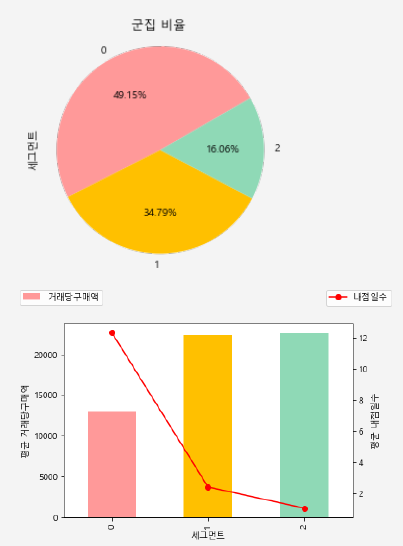

## 2-2. 건강식품

- 클러스터 1 & 클러스터 2 에서 거래당 구매액 높게 나타나는 이유

In [ ]:
ff.groupby('세그먼트')['거래당구매액'].mean().plot.bar(color = colors)
plt.xticks(rotation = 0)
plt.show()

In [ ]:
fff = food.merge(ff[['ID','세그먼트']], on = 'ID')

pd.DataFrame({customers:
              fff[fff['세그먼트'] == customers].상품중분류명.value_counts().head(5).index for customers in fff.세그먼트.unique()})[[0,1,2]]

In [ ]:
food.groupby('상품중분류명')['구매금액'].mean().sort_values(ascending = False).plot.bar(color = colors_items[0], label = None)
plt.title('식품 상품중분류 별 평균 금액')
plt.show()

# 3. Nofood

## 3-1. RFM 분석

In [ ]:
# R
# 최종 구매일 다음날을 기준으로 계산 
now = nofood.구매일자.max()+pd.DateOffset(days=1)

# method chaining (multi-line)
recency = (nofood.groupby('ID')['구매일자']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'구매일자':'recency'})
          )
recency.head()

In [ ]:
# F
frequency = nofood.ID.value_counts().reset_index().rename(columns={'index' : 'ID', 'ID' : 'frequency'})
frequency.head()

In [ ]:
# M
monetary = nofood.groupby('ID')['구매금액'].agg([('monetary', np.sum)]).reset_index()
monetary.head()

In [ ]:
# 위에서 만든 3개의 data_frame를 merge
rfm = recency.merge(frequency).merge(monetary)
rfm.head()

In [ ]:
# recency, frequency, monetary 값을 각각 5분위로 분류하여 점수 부여
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=range(5,0,-1)).astype(int)
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=range(1,6)).astype(int)
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=range(1,6)).astype(int)
rfm.head()

In [ ]:
# R,F,M 점수를 조합하여 RFM 그룹 생성
rfm['RFMgroup'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

In [ ]:
# 고객군 분류

best = list(rfm.loc[rfm['RFMgroup'] == '333'].index) #333
lost_cheap = list(rfm.loc[rfm['RFMgroup'] == '111'].index) #111
lost = list(rfm.loc[rfm['RFMgroup'] == '133'].index) #133
lost_almost = list(rfm.loc[rfm['RFMgroup'] == '233'].index) #233

rfm['Segment'] = 0

for i in rfm.index :
    if i in lost_cheap :
        rfm['Segment'].iloc[i] = 'Lost Cheap Customers'
    elif i in lost : 
        rfm['Segment'].iloc[i] = 'Lost Customer'
    elif i in best : 
        rfm['Segment'].iloc[i] = 'Best Customer'
    elif i in lost_almost : 
        rfm['Segment'].iloc[i] = 'Almost Lost'
    else : 
        rfm['Segment'].iloc[i] = 'Other'

In [ ]:
loyal = list(rfm.loc[rfm['F'] == 3].index) #그 외 RFM group에서 F 3인 그룹
loyal2 = []

for i in loyal :
    if i not in best and i not in lost_cheap and i not in lost_almost and i not in lost :
        loyal2.append(i)

for i in rfm.index :
    if i in loyal2:
        rfm.Segment.iloc[i] = 'Loyal Customers'

In [ ]:
big = list(rfm.loc[rfm['M'] == 3].index) # 그 외 RFM group에서 M 3인 그룹
big2 = []

for i in big :
    if i not in best and i not in lost_cheap and i not in lost_almost and i not in lost :
        big2.append(i)

for i in rfm.index :
    if i in big2:
        rfm.Segment.iloc[i] = 'Big Spenders'

In [ ]:
md = pd.merge(nofood, rfm)
md.head()

In [ ]:
md.head()

In [ ]:
sq1 = md.groupby('Segment')['구매금액'].sum().sort_values(ascending = False).reset_index()
sq1.drop([0], inplace = True) #Segment "other" 제거

In [ ]:
sq2 = md.groupby('Segment')['ID'].nunique().reindex(index = sq1.Segment.values).reset_index()
sq2

In [ ]:
colors_seg = matplotlib.cm.get_cmap('Set1')(np.arange(len(sq1)))

plt.figure(figsize=(10,8))
sns.scatterplot(x="구매금액", 
                y='ID',
                s=1000, alpha=0.5,
                hue="Segment",
                data=sq1.merge(sq2, on = 'Segment'), palette = colors_seg)
plt.xlabel("총 구매금액")
plt.ylabel("고객 수")
plt.grid(True)
plt.show()

**RFM 분석 결과**
1. RFM 지수가 높으며 총구매금액이 높고, 고객 수도 많은 `Loyal Customers` & `Big Spenders` 주고객층으로 설정
2. RFM 지수 낮으며 총구매금액이 낮고, 고객 수도 적은 `Almost Lost` & `Lost Customer` 이탈고객으로 설정

In [ ]:
pd.DataFrame({customers:
              md[md['Segment'] == customers].상품중분류명.value_counts().head(5).index for customers in sq1.Segment.unique()})

## 3-2. 의류잡화

- 총 구매금액이 가장 높게 나타나는 `의류잡화`에 초점

In [ ]:
nofood.groupby('상품대분류명')['구매금액'].sum().sort_values(ascending = False).plot.bar(color = colors_items[1:])
plt.xticks(rotation = 0)
plt.show()

### 3-2-1. 주얼리

- 의류잡화 중 금액대가 높은 `주얼리`에 대한 분석 진행

In [ ]:
nofood[nofood['상품대분류명'] == '의류잡화'].groupby('상품중분류명')['구매금액'].mean().sort_values(ascending = False).plot.barh(color = colors_items[1])
plt.show()

In [ ]:
# 해당 상품군 데이터 추출
jewelry = nofood[nofood['상품중분류명'] == '주얼리']

# 전체 구매시간별 구매 비율
all_jewelry = jewelry['구매시간'].value_counts(normalize = True).sort_index().rename('전체')
all_jewelry

In [ ]:
# 평일 구매시간별 구매 비율
weekday_jewelry = jewelry[jewelry['평일주말'] == '평일']['구매시간'].value_counts(normalize = True).sort_index().rename('평일')
weekday_jewelry

In [ ]:
# 주말 구매시간별 구매 비율
weekend_jewelry = jewelry[jewelry['평일주말'] == '주말']['구매시간'].value_counts(normalize = True).sort_index().rename('주말')
weekend_jewelry

In [ ]:
# 데이터 합치기
time_jewerly = pd.concat([all_jewelry, weekday_jewelry, weekend_jewelry], axis = 1)
time_jewerly

In [ ]:
sns.heatmap(time_jewerly, cmap='YlOrBr', linewidths=1, vmin=0, annot=True, annot_kws={'size':12})
plt.title('주얼리 시간대별 구매 비율 비교', fontsize=13)
plt.show()

### 3-2-2. 캐주얼

**실버세대의 캐주얼에 대한 관심 증가**

- 백진엽, '응사' '꽃보다할배'의 경제효과는 얼마?, new1, https://www.news1.kr/articles/1505129

평균 연령 76세의 꽃할배 4인방의 파란만장 배낭여행기를 담은 '꽃보다 할배'는 `실버 세대가 즐길 수 있을만한 다양한 문화 공연 및 레저산업`이 활기를 띠게 되는 계기를 마련했다는 평가다. 아울러 젊은층이 즐겨찾는 `'이지캐주얼' 의류를 구매한 60대 이상 고객 매출도 동반상승, 실버 산업의 새로운 트렌드`를 이끌었다.

In [ ]:
casuals = ['여성용의류-캐주얼', '남성용의류-캐주얼']

fig, axes = plt.subplots(1,2, figsize=(10,6), sharey=True)

# 주얼리의 과정 반복
for casual in casuals :
    item = nofood[nofood['상품중분류명'] == casual]
    all_item = item['구매시간'].value_counts(normalize = True).sort_index().rename('전체')
    weekday_item = item[item['평일주말'] == '평일']['구매시간'].value_counts(normalize = True).sort_index().rename('평일')
    weekend_item = item[item['평일주말'] == '주말']['구매시간'].value_counts(normalize = True).sort_index().rename('주말')
    time_item = pd.concat([all_item, weekday_item, weekend_item], axis = 1)
    sns.heatmap(time_item, cmap='YlOrBr', ax=axes[casuals.index(casual)], linewidths=1, vmin=0, annot=True, annot_kws={'size':12})
    axes[casuals.index(casual)].set_title(str(casual)+' 시간대별 구매 비율 비교', fontsize=13)

plt.show()

## 3-3. 가전제품

- 다른 제품군과 다르게 계절별 구매수량 편차가 큰 `가전제품`에 대한 분석 진행

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

for i in list(df.상품대분류명.value_counts().index[1:]):
    nofood.query('상품대분류명==@i').구매계절\
    .value_counts()[['봄','여름','가을','겨울']].plot(label=i, marker='s', markersize=7, color = colors_items[list(df.상품대분류명.value_counts().index[1:]).index(i)+1])

ax.set_xlabel('계절', size=15)
ax.set_ylabel('구매수량', size=15)
    
plt.title('비식품 계절 별 상품대분류의 구매수량', size=20)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# 가장 적은 봄과 가장 많은 가을 3.3배 차이

nofood.query('상품대분류명=="가전제품"').구매계절\
.value_counts()[['봄','여름','가을','겨울']].max()/nofood.query('상품대분류명=="가전제품"').구매계절\
.value_counts()[['봄','여름','가을','겨울']].min()

### 3-3-1. 결혼 시기와 연관
- 혼수 관련 제품

In [ ]:
marriage = pd.read_excel('marriage.xlsx')
marriage = marriage.set_index('연도')
marriage

In [ ]:
marriage = marriage.loc[:, '1월':'12월'].apply(lambda x : x*1000)
marriage[['봄', '여름', '가을', '겨울']] = 0
for i in marriage.columns[:-4] :
    marriage[season(int(i[:-1]))] += marriage[i]
marriage

In [ ]:
local_marriage = pd.read_csv('시도_시군구_월별_혼인_20210604161106.csv', encoding='cp949', engine='python')
local_marriage = local_marriage.set_index('시군구별')
local_marriage

In [ ]:
local_marriage[['봄', '여름', '가을', '겨울']] = 0
for i in local_marriage.columns[:-4] :
    local_marriage[season(int(i[-2:]))] += local_marriage[i]
local_marriage

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

xlabels = ['봄','여름','가을','겨울']

marriage.iloc[0, -4:].T.plot(ax = axes[0], color='red', marker='o')
axes[0].set_title('2004년~2014년 전국 계절 별 혼인건수', size = 20)

local_marriage.iloc[:, -4:].T.plot.bar(ax = axes[1], color=['gold','darkblue','green'], stacked=True)
axes[1].set_title('2014년 서울,부산,경기도의 계절 별 혼인건수', size = 20)
axes[1].legend(bbox_to_anchor=(1,1))

plt.show()

**분석 결과**
1. 가전제품 계절별 판매 비율을 볼 때, `가을 >겨울` > 여름 > 봄
2. 전국과 데이터에 반영된 지역(서울, 부산, 경기)의 계절별 혼인 건수를 볼 때, `겨울 > 봄` > 여름 > 가을

### 3-3-2. 가을 & 주방가전
- 계절 중 가장 많이 판매되는 `가을`에 초점
- 특히, 가전제품 중 높은 판매 비율을 갖는 `주방가전`

In [ ]:
# 해당 상품군 데이터 추출
ele = nofood.query("상품대분류명 == '가전제품'")

In [ ]:
colors_season = matplotlib.cm.get_cmap('tab20c')(np.arange(4))

pd.crosstab(ele.상품중분류명, ele.구매계절, 
            normalize=True, margins=True)[['봄', '여름', '가을', '겨울']].reindex(ele.상품중분류명.value_counts().index).plot.barh(stacked = True, color = colors_season)
plt.title('가전제품 상품중분류 기준 계절별 판매비율')
plt.show()

In [ ]:
# 주방 가전 월별 판매 금액 비교
month = [i for i in range(1,13)]

colors_month = ['#304169', '#304169',
                '#445C95', '#445C95', '#445C95',
               '#627BB7', '#627BB7', '#627BB7',
               '#8DA0CB', '#8DA0CB', '#8DA0CB', '#304169']

fig, axes = plt.subplots(1,2, figsize=(20,5))

ele.query("상품중분류명 == '주방가전'").groupby('구매월')['구매금액'].sum().plot.bar(ax = axes[0], color = colors_month)
axes[0].set_title('주방가전 월별 총 판매금액', size = 20)
axes[0].set_xticklabels(month, rotation = 0)

ele.query("상품중분류명 == '주방가전'").groupby('구매월')['구매금액'].mean().plot.bar(ax = axes[1], color = colors_month)
axes[1].set_title('주방가전 월별 건당 평균 판매금액', size = 20)
axes[1].set_xticklabels(month, rotation = 0)

plt.show()

In [ ]:
# 주방가전 11월 내역 중 금액 상위 10위
ele.query("상품중분류명 == '주방가전' and 구매월 == 11").sort_values(by = '구매금액', ascending = False)['구매금액'][:10].values

**분석 결과**
1. 매출이 좋은 가을 중 특히 가장 높은 매출을 보이는 `11월`
2. 11월에 판매된 상품 중 주방가전의 금액을 나열해보았을 때, 가격대를 보아 냉장고와 같은 상품이 많이 팔렸음을 추정